# Twitter Tweets Sentiment Models

## Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Y3S1-cloud/TXSA(G12)/Tweets.csv") #erwin's
#df = pd.read_csv("/content/drive/MyDrive/Y3S1/TXSA-G12/Tweets.csv") #tracy
#df = pd.read_csv("Tweets.csv") #angeline

In [ ]:
# Count the number of entries for each sentiment category
sentiment_counts = df['sentiment'].value_counts()
total_entries = len(df)
target_size = 8000  # Target size of the dataset

# Calculate the ratio for each sentiment category
ratios = sentiment_counts / total_entries

# Calculate the number of entries to sample from each category to maintain the ratio
samples_per_category = (ratios * target_size).round().astype(int)

# Adjust sample sizes if they exceed the available entries
samples_per_category = samples_per_category.clip(upper=sentiment_counts)

# Mark entries for keeping
df['keep'] = False
for sentiment, sample_size in samples_per_category.items():
    indices_to_keep = df[df['sentiment'] == sentiment].sample(sample_size, random_state=42).index
    df.loc[indices_to_keep, 'keep'] = True

# Filter the dataframe to keep only marked entries
df = df[df['keep']].drop('keep', axis=1)

## Data Understanding

In [ ]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
8,e050245fbd,Both of you,Both of you,neutral
17,919fa93391,i`ve been sick for the past few days and thus...,sick,negative


In [ ]:
df.columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

In [ ]:
df.shape

(8000, 4)

In [ ]:
df.sentiment.value_counts()

neutral     3237
positive    2498
negative    2265
Name: sentiment, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         8000 non-null   object
 1   text           8000 non-null   object
 2   selected_text  8000 non-null   object
 3   sentiment      8000 non-null   object
dtypes: object(4)
memory usage: 312.5+ KB


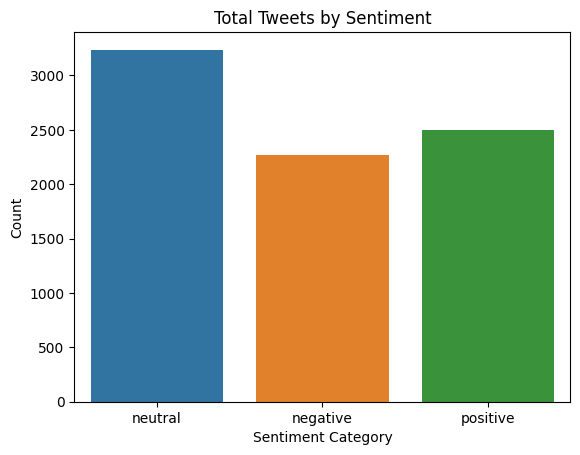

In [ ]:
sns.countplot(x=df['sentiment'])
plt.title('Total Tweets by Sentiment')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

In [ ]:
from collections import Counter
import itertools

# Splitting words in each tweet and flattening the list
all_words = list(itertools.chain(*df['text'].str.split()))

# Counting the frequency of each word
word_freq = Counter(all_words)

# Most common words
most_common_words = word_freq.most_common(20)

# Converting most common words to a DataFrame
most_common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

most_common_words_df

,Word,Frequency
0,to,2848
1,I,2591
2,the,2438
3,a,1873
4,my,1441
5,and,1406
6,i,1212
7,you,1157
8,is,1082
9,for,1067


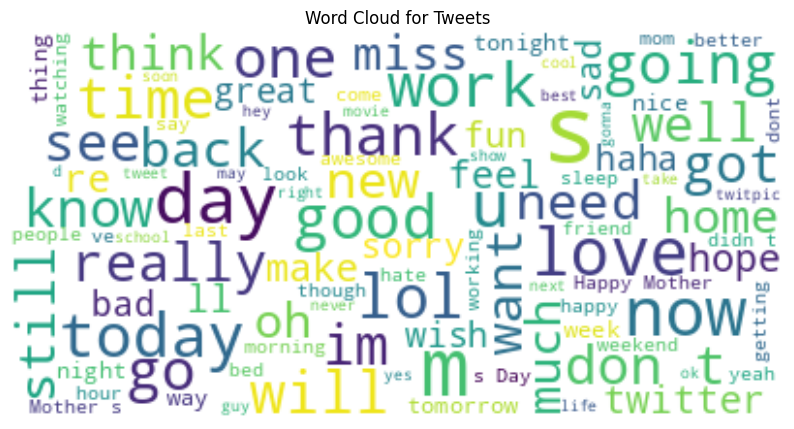

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(df['text'].astype(str)))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Tweets")
plt.show()

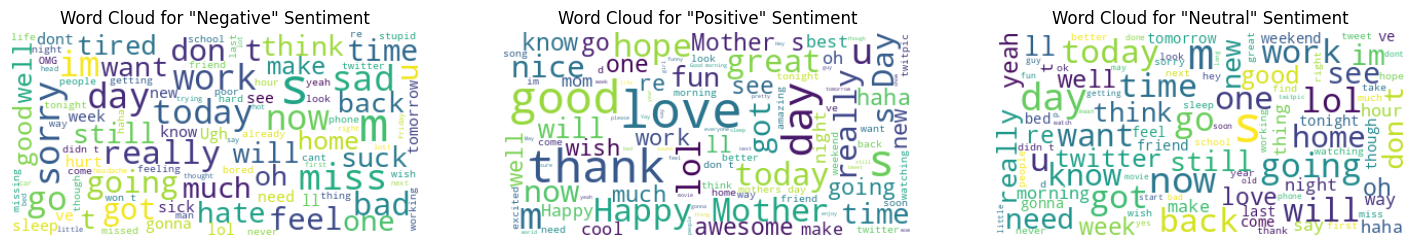

In [ ]:
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# Generating word clouds for each category
wordcl_negative = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(negative_df['text'].astype(str)))
wordcl_positive = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(positive_df['text'].astype(str)))
wordcl_neutral = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(neutral_df['text'].astype(str)))

# Plotting the word clouds
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(wordcl_negative, interpolation='bilinear')
plt.title('Word Cloud for "Negative" Sentiment')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(wordcl_positive, interpolation='bilinear')
plt.title('Word Cloud for "Positive" Sentiment')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(wordcl_neutral, interpolation='bilinear')
plt.title('Word Cloud for "Neutral" Sentiment')
plt.axis("off")

plt.show()

## Data Preparation & Cleaning

In [ ]:
df = df.drop(columns=['textID', 'selected_text'])

In [ ]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
df = df[df['sentiment'] != 'neutral']

In [ ]:
df.loc[:, 'label'] = df['sentiment'].apply(lambda x: 0 if x == 'positive' else 1)

In [ ]:
df.columns

Index(['text', 'sentiment', 'label'], dtype='object')

In [ ]:
df.shape

(4763, 3)

In [ ]:
df.head()

,text,sentiment,label
1,Sooo SAD I will miss you here in San Diego!!!,negative,1
6,2am feedings for the baby are fun when he is a...,positive,0
17,i`ve been sick for the past few days and thus...,negative,1
33,That`s very funny. Cute kids.,positive,0
36,Born and raised in NYC and living in Texas for...,negative,1


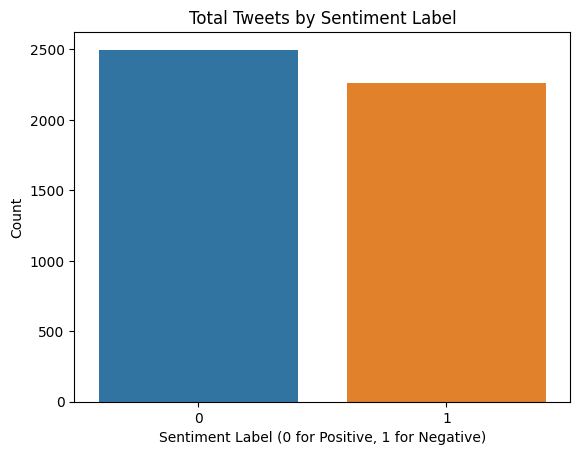

In [ ]:
sns.countplot(x=df['label'])
plt.title('Total Tweets by Sentiment Label')
plt.xlabel('Sentiment Label (0 for Positive, 1 for Negative)')
plt.ylabel('Count')
plt.show()

### Informal to standard mapping

In [ ]:
informal_to_standard = {
    "b4": "before",
    "u": "you",
    "r": "are",
    "2": "to",
    "4": "for",
    "gr8": "great",
    "l8r": "later",
    "brb": "be right back",
    "btw": "by the way",
    "lol": "laugh out loud",
    "omg": "oh my god",
    "thx": "thanks",
    "pls": "please",
    "idk": "I don't know",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "irl": "in real life",
    "jk": "just kidding",
    "k": "okay",
    "np": "no problem",
    "rofl": "rolling on the floor laughing",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "ttyl": "talk to you later",
    "ty": "thank you",
    "w/": "with",
    "w/o": "without",
    "y": "why",
    "yr": "your",
    "atm": "at the moment",
    "b/c": "because",
    "bff": "best friends forever",
    "cya": "see you",
    "fyi": "for your information",
    "gg": "good game",
    "gtg": "got to go",
    "hbu": "how about you",
    "idc": "I don't care",
    "ily": "I love you",
    "ilu": "I love you",
    "lmao": "laughing my a** off",
    "nvm": "never mind",
    "ofc": "of course",
    "omw": "on my way",
    "pov": "point of view",
    "qt": "cutie",
    "sup": "what's up",
    "tmi": "too much information",
    "yolo": "you only live once",
    "bruh": "brother",
    "fam": "family",
    "lit": "amazing",
    "noob": "newbie",
    "pwn": "dominate",
    "slay": "do really well",
    "yeet": "to throw",
    "zzz": "sleeping",
    "fml": "f*** my life",
    "asap": "as soon as possible",
    "afk": "away from keyboard",
    "bae": "before anyone else",
    "m8": "mate",
    "sos": "help",
    "sus": "suspicious",
    "wbu": "what about you",
    "yw": "you're welcome",
    "gl": "good luck",
    "hf": "have fun",
    "np": "no problem",
    "ty": "thank you",
    "ttyl": "talk to you later",
    "i`m": "i am",
    "i`ve": "i have",
    "i`ll": "i will",
    "i`d": "i would",
    "you`re": "you are",
    "you`ve": "you have",
    "you`ll": "you will",
    "you`d": "you would",
    "he`s": "he is",
    "he`ll": "he will",
    "he`d": "he would",
    "she`s": "she is",
    "she`ll": "she will",
    "she`d": "she would",
    "it`s": "it is",
    "it`ll": "it will",
    "it`d": "it would",
    "we`re": "we are",
    "we`ve": "we have",
    "we`ll": "we will",
    "we`d": "we would",
    "they`re": "they are",
    "they`ve": "they have",
    "they`ll": "they will",
    "they`d": "they would",
    "that`s": "that is",
    "that`ll": "that will",
    "that`d": "that would",
    "there`s": "there is",
    "there`re": "there are",
    "there`ll": "there will",
    "there`d": "there would",
    "who`s": "who is",
    "who`ll": "who will",
    "who`d": "who would",
    "what`s": "what is",
    "what`re": "what are",
    "what`ll": "what will",
    "what`d": "what would",
    "where`s": "where is",
    "where`ll": "where will",
    "where`d": "where would",
    "when`s": "when is",
    "when`ll": "when will",
    "when`d": "when would",
    "why`s": "why is",
    "why`ll": "why will",
    "why`d": "why would",
    "how`s": "how is",
    "how`ll": "how will",
    "how`d": "how would",
    "n" : "and",
}

### Clean Data Original

In [ ]:
def replace_informal(text):
    words = text.split()
    return ' '.join([informal_to_standard.get(word.lower(), word) for word in words])

In [ ]:
df['Clean_Text1'] = df['text'].apply(replace_informal)

In [ ]:
df

,text,sentiment,label,Clean_Text1
1,Sooo SAD I will miss you here in San Diego!!!,negative,1,Sooo SAD I will miss you here in San Diego!!!
6,2am feedings for the baby are fun when he is a...,positive,0,2am feedings for the baby are fun when he is a...
17,i`ve been sick for the past few days and thus...,negative,1,i have been sick for the past few days and thu...
33,That`s very funny. Cute kids.,positive,0,that is very funny. Cute kids.
36,Born and raised in NYC and living in Texas for...,negative,1,Born and raised in NYC and living in Texas for...
...,...,...,...,...
27463,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MIS...,negative,1,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MISS...
27465,Sure. I`ll try n keep that up! =P You enjoy s...,positive,0,Sure. i will try and keep that up! =P You enjo...
27474,So I get up early and I feel good about the da...,positive,0,So I get up early and I feel good about the da...
27477,I`ve wondered about rake to. The client has ...,negative,1,i have wondered about rake to. The client has ...


In [ ]:
def clean_text(text):
    # Combine punctuation and stopwords into a set for efficient searching
    bad_tokens = set(punctuation).union(set(stopwords.words('english')))

    # Initialize the lemmatizer
    lemma = WordNetLemmatizer()

    # Tokenize and process the text
    tokens = word_tokenize(text.lower())
    clean_tokens = [lemma.lemmatize(t) for t in tokens if t.isalpha() and t not in bad_tokens]

    return ' '.join(clean_tokens)

In [ ]:
df['Clean_Text2'] = df['Clean_Text1'].apply(clean_text)

In [ ]:
df

,text,sentiment,label,Clean_Text1,Clean_Text2
1,Sooo SAD I will miss you here in San Diego!!!,negative,1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego
6,2am feedings for the baby are fun when he is a...,positive,0,2am feedings for the baby are fun when he is a...,feeding baby fun smile coo
17,i`ve been sick for the past few days and thus...,negative,1,i have been sick for the past few days and thu...,sick past day thus hair look wierd didnt hat w...
33,That`s very funny. Cute kids.,positive,0,that is very funny. Cute kids.,funny cute kid
36,Born and raised in NYC and living in Texas for...,negative,1,Born and raised in NYC and living in Texas for...,born raised nyc living texas past year still m...
...,...,...,...,...,...
27463,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MIS...,negative,1,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MISS...,like drew said tc chance miss thomas move watc...
27465,Sure. I`ll try n keep that up! =P You enjoy s...,positive,0,Sure. i will try and keep that up! =P You enjo...,sure try keep enjoy studying cya
27474,So I get up early and I feel good about the da...,positive,0,So I get up early and I feel good about the da...,get early feel good day walk work feeling alri...
27477,I`ve wondered about rake to. The client has ...,negative,1,i have wondered about rake to. The client has ...,wondered rake client made clear force devs lea...


In [ ]:
nlp = spacy.load("en_core_web_sm")

def clean_text2(text):
    doc = nlp(text)
    cleaned_text = []

    for token in doc:
        # Check if the token is a stop word, punctuation, or not an alpha character
        if not token.is_stop and not token.is_punct and token.is_alpha:
            # Append the lemmatized, lowercase version of the token
            cleaned_text.append(token.lemma_.lower())

    return ' '.join(cleaned_text)

In [ ]:
df['Clean_Text3'] = df['Clean_Text2'].apply(clean_text2)

In [ ]:
df

,text,sentiment,label,Clean_Text1,Clean_Text2,Clean_Text3
1,Sooo SAD I will miss you here in San Diego!!!,negative,1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego,sooo sad miss san diego
6,2am feedings for the baby are fun when he is a...,positive,0,2am feedings for the baby are fun when he is a...,feeding baby fun smile coo,feed baby fun smile coo
17,i`ve been sick for the past few days and thus...,negative,1,i have been sick for the past few days and thu...,sick past day thus hair look wierd didnt hat w...,sick past day hair look wierd not hat look http
33,That`s very funny. Cute kids.,positive,0,that is very funny. Cute kids.,funny cute kid,funny cute kid
36,Born and raised in NYC and living in Texas for...,negative,1,Born and raised in NYC and living in Texas for...,born raised nyc living texas past year still m...,bear raise nyc living texas past year miss ny
...,...,...,...,...,...,...
27463,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MIS...,negative,1,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MISS...,like drew said tc chance miss thomas move watc...,like drew say tc chance miss thomas watch http
27465,Sure. I`ll try n keep that up! =P You enjoy s...,positive,0,Sure. i will try and keep that up! =P You enjo...,sure try keep enjoy studying cya,sure try enjoy study cya
27474,So I get up early and I feel good about the da...,positive,0,So I get up early and I feel good about the da...,get early feel good day walk work feeling alri...,early feel good day walk work feel alright gue...
27477,I`ve wondered about rake to. The client has ...,negative,1,i have wondered about rake to. The client has ...,wondered rake client made clear force devs lea...,wonder rake client clear force devs learn new ...


In [ ]:
def correct_spelling(text):
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    corrected_text = str(TextBlob(text).correct())
    return corrected_text

In [ ]:
df['Clean_Text4'] = df['Clean_Text3'].apply(correct_spelling)

In [ ]:
df

,text,sentiment,label,Clean_Text1,Clean_Text2,Clean_Text3,Clean_Text4
1,Sooo SAD I will miss you here in San Diego!!!,negative,1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego,sooo sad miss san diego,so sad miss san diego
6,2am feedings for the baby are fun when he is a...,positive,0,2am feedings for the baby are fun when he is a...,feeding baby fun smile coo,feed baby fun smile coo,feed baby fun smile too
17,i`ve been sick for the past few days and thus...,negative,1,i have been sick for the past few days and thu...,sick past day thus hair look wierd didnt hat w...,sick past day hair look wierd not hat look http,sick past day hair look wired not hat look http
33,That`s very funny. Cute kids.,positive,0,that is very funny. Cute kids.,funny cute kid,funny cute kid,funny cut kid
36,Born and raised in NYC and living in Texas for...,negative,1,Born and raised in NYC and living in Texas for...,born raised nyc living texas past year still m...,bear raise nyc living texas past year miss ny,bear raise ny living texas past year miss ny
...,...,...,...,...,...,...,...
27463,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MIS...,negative,1,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MISS...,like drew said tc chance miss thomas move watc...,like drew say tc chance miss thomas watch http,like drew say to chance miss thomas watch http
27465,Sure. I`ll try n keep that up! =P You enjoy s...,positive,0,Sure. i will try and keep that up! =P You enjo...,sure try keep enjoy studying cya,sure try enjoy study cya,sure try enjoy study cy
27474,So I get up early and I feel good about the da...,positive,0,So I get up early and I feel good about the da...,get early feel good day walk work feeling alri...,early feel good day walk work feel alright gue...,early feel good day walk work feel alright gue...
27477,I`ve wondered about rake to. The client has ...,negative,1,i have wondered about rake to. The client has ...,wondered rake client made clear force devs lea...,wonder rake client clear force devs learn new ...,wonder rake client clear force des learn new l...


In [ ]:
df2 = df.drop(columns=['text', 'sentiment','Clean_Text1','Clean_Text2','Clean_Text3'])

In [ ]:
#df2.to_csv("/content/drive/MyDrive/Y3S1-cloud/TXSA(G12)/CleanedTweets.csv", index=False) #export the clean data for SAS

## Build Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score, ConfusionMatrixDisplay, classification_report

pos = df[df['label'] == 0].sample(2000, replace=True)
neg = df[df['label'] == 1].sample(2000, replace=True)

# Concatenate pos and neg labels
df = pd.concat([pos, neg], axis=0)
df.shape

(4000, 7)

In [ ]:
X = df['Clean_Text4']
y = df['label']

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model 1: Support Vector Classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV with SVC and the parameter grid
grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Validated Score (accuracy)", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Validated Score (accuracy) 0.9078125


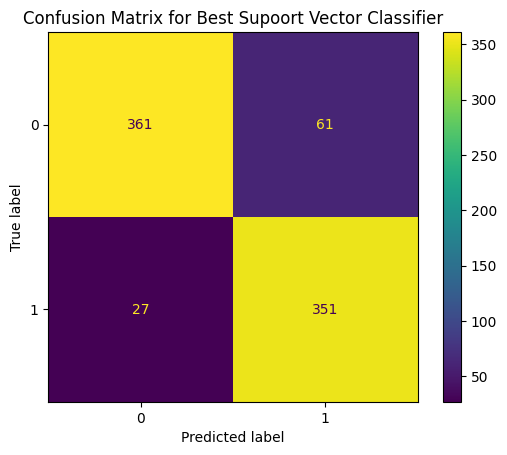

Classification Report for Best Supoort Vector Classifier: 

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       422
           1       0.85      0.93      0.89       378

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use the best model from GridSearchCV to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Function to visualize model results
def eval(model_name, y_test, y_pred):
    # Generating and displaying a confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot()
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Printing classification report
    print(f'Classification Report for {model_name}: \n')
    print(classification_report(y_test, y_pred))

# Evaluate the model
eval('Best Supoort Vector Classifier', y_test, y_pred)

### Model 2: Logistic Regression

In [ ]:
# Import necessary libraries and functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


# Define the parameter grid for GridSearchCV
param_grid = {
    'random_state': [42],
    'C': [1, 10, 20, 30, 40, 50],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'max_iter': [10000]
}

# Initialize the GridSearchCV object with LogisticRegression and the defined param_grid
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# Perform the grid search on the smaller training data subset
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best model to make predictions on the test set for the first configuration
LR_best_model = grid_search.best_estimator_
y_pred = LR_best_model.predict(X_test)

# Evaluate the best model for the first configuration
accuracy = accuracy_score(y_test, y_pred)

# Print the results for the first configuration
print("Best Hyperparameters:", best_params)
print("Best Validated Score (accuracy)", best_score)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
Best Validated Score (accuracy) 0.9003125000000001
Accuracy on Test Set: 0.89


Classification Report for Logistic Regression: 

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       422
           1       0.85      0.93      0.89       378

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



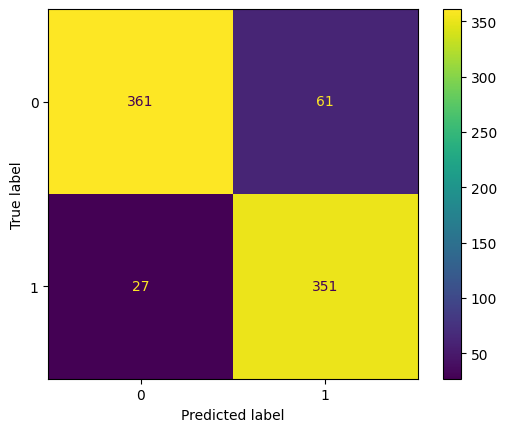

In [ ]:
# Define a function to visualize and evaluate model performance
def eval(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred) # Calculate the confusion matrix
    t1 = ConfusionMatrixDisplay(cm) # Initialize a display object for the confusion matrix

    # Print a classification report with main classification metrics
    print('Classification Report for Logistic Regression: \n')
    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    t1.plot()

# Call the function to display the evaluation results
eval('Classification Report', y_test, y_pred)

### Model 3: Random Forest

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

Classification Report for Random Forest Classifier: 

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       422
           1       0.89      0.91      0.90       378

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



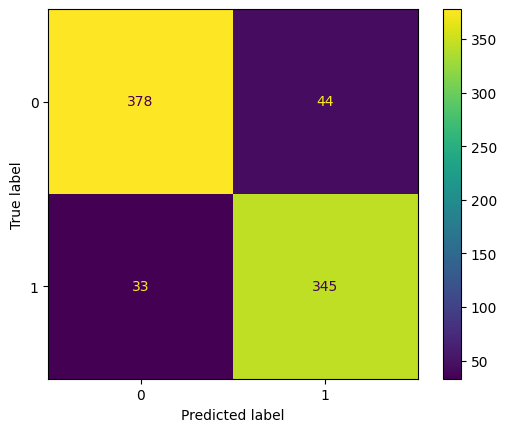

In [ ]:
y_pred = model.predict(X_test)

#Defining a function to evaluate model results
def eval(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print('Classification Report for Random Forest Classifier: \n')
    print(classification_report(y_test, y_pred))
    t1.plot()
eval('Classification Report', y_test, y_pred)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Set the parameter grid for the first configuration
param_grid_1 = {
    'n_estimators': [200, 250],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
}

# Create the Random Forest classifier
rf_model = RandomForestClassifier()

# Create the GridSearchCV object for the first configuration
grid_search_1 = GridSearchCV(estimator=rf_model, param_grid=param_grid_1, cv=3, scoring='accuracy', n_jobs=-1)

# Perform the grid search on the smaller training data subset
grid_search_1.fit(X_train, y_train)

# Get the best parameters and the best cross-validated score for the first configuration
best_params_1 = grid_search_1.best_params_
best_score_1 = grid_search_1.best_score_

# Use the best model to make predictions on the test set for the first configuration
best_model_1 = grid_search_1.best_estimator_
y_pred_1 = best_model_1.predict(X_test)

# Evaluate the best model for the first configuration
accuracy_1 = accuracy_score(y_test, y_pred_1)

# Print the results for the first configuration
print("Best Hyperparameters (Configuration 1):", best_params_1)
print("Best Validated Score (accuracy) - Configuration 1:", best_score_1)
print("Accuracy on Test Set (Configuration 1):", accuracy_1)

Best Hyperparameters (Configuration 1): {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}
Best Validated Score (accuracy) - Configuration 1: 0.8228110000802985
Accuracy on Test Set (Configuration 1): 0.81125


Classification Report for Random Forest Classifier: 

              precision    recall  f1-score   support

           0       0.95      0.71      0.81       422
           1       0.75      0.96      0.84       378

    accuracy                           0.83       800
   macro avg       0.85      0.83      0.83       800
weighted avg       0.86      0.83      0.83       800



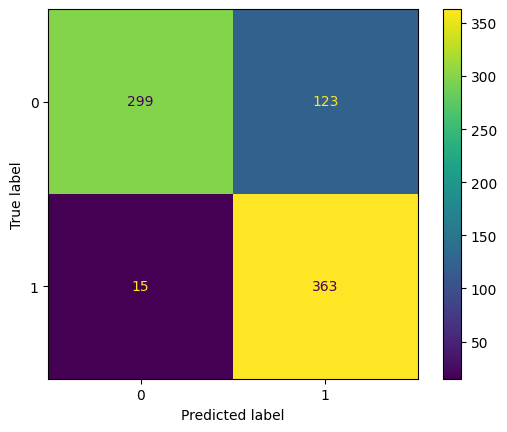

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

def train_evaluate_random_forest(X, y, n_estimators=250, max_depth=15, min_samples_split=5, min_samples_leaf=4, max_features='sqrt', bootstrap=True):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create the RandomForestClassifier with specified hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Define the evaluation function
    def eval(name, y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)
        t1 = ConfusionMatrixDisplay(cm)
        print(f'Classification Report for {name}: \n')
        print(classification_report(y_test, y_pred))
        t1.plot()

    # Call the eval function with the model
    eval('Random Forest Classifier', y_test, y_pred)

    # Return the trained model
    return model

# Trained Random Forest Model:
trained_rf_model = train_evaluate_random_forest(X, y, n_estimators=200, max_depth=15, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=False)

## Model Evaluation

In [ ]:
# Function to evaluate and compare models in terms of accuracy and F1 score
def compare_models_metrics(X_test, y_test, models):
    for name, model in models.items():
        y_pred = model.predict(X_test)

        # Calculate accuracy and F1 score
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Print the metrics
        print(f'Model: {name}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print('\n')

# Import necessary library
from sklearn.metrics import f1_score

# Define models to compare
models = {
    'Support Vector Classifier' : best_model,
    'Logistic Regression': LR_best_model,
    'Random Forest Classifier': model
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)

# Compare models in terms of accuracy and F1 score
compare_models_metrics(X_test, y_test, models)

Model: Support Vector Classifier
Accuracy: 0.8900
F1 Score: 0.8901


Model: Logistic Regression
Accuracy: 0.8900
F1 Score: 0.8901


Model: Random Forest Classifier
Accuracy: 0.8250
F1 Score: 0.8233


